# Setup

In [2]:
import gym
import tensorflow as tf
import retro

import numpy as np
import random as r

from skimage import transform # to preprocess game frames
from skimage.color import rgb2gray # to convert game frames into grayscale
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import optimizers

from collections import deque # to create ordered collections of frames

# Create Env

Frame Size:  Box(210, 160, 3)
Action Space:  6  moves

This is what the agent sees: 


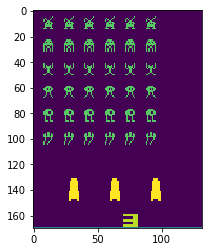

In [3]:
env = gym.make('SpaceInvaders-v0') # make env

print("Frame Size: ", env.observation_space)
print("Action Space: ", env.action_space.n, " moves")

UP = 26
DOWN = -14
LEFT = 14
RIGHT = -14

H = 210 - (UP - DOWN) # height of preprocessed image
W = 160 - (LEFT - RIGHT) # width of preprocessed image

obs = env.reset()[UP:DOWN, LEFT:RIGHT]
obs = obs[:, :, 0]

%matplotlib inline
img = Image.fromarray(obs, 'L')

print("\nThis is what the agent sees: ")
imshow(np.asarray(img))

# Hyperparameters

In [4]:
# model
NUM_FRAMES = 4 # "phi length" - how many frames we consolidate into one training example
X_DIMS = (H, W, NUM_FRAMES)# input dimensions to NN 
NUM_POSSIBLE_ACTIONS = env.action_space.n # 6 possible moves
LEARNING_RATE = 2.5e-4

# training
NUM_GAMES = 300 # how many games we will play for training
HIDDEN_UNITS = 512
BATCH_SIZE = 24 # num of states we include for each weight update in gradient descent

# explore params
EXPLORE = 5e-6

# q le table
GAMMA = 0.9 # discount for future rewards in bellman equation

# memory
# LOAD_MEM = 64 # num experiences to be stored in memory during initialization
# MEMORY_SIZE = int(1e6) # max num experiences stored in memory

# Preprocess raw input from game

In [5]:
def process_state(state):
    
#     print("Input Size: ", state.shape)
    
    gray_doe = rgb2gray(state)
    crop_doe = gray_doe[UP:DOWN, LEFT:RIGHT]
    observation = crop_doe / 255.0
    
#     print("Output Size: ", frame.shape)
    
    return observation # Shape = 172 height, 132 width | vals = [0, 1]

In [6]:
def add_observation(observations, state, game_step):
    
    obs = process_state(state)
    
    if game_step == 0: # new game
        for image in range(len(observations)):
            observations.append(obs)
    
    else:
        observations.append(obs)
    
    return observations
        

In [11]:
def get_move(model, observations, moves, training_step):
    
    adventure = r.uniform(0, 1)

    explore_prob = min(EXPLORE * training_step, 0.9)

    if explore_prob < adventure: # explore randomly
        choice = r.randint(1, len(moves)) - 1
        action = moves[choice]
        
    else: # use dqn
        obs = np.stack(observations, axis=2)
        dq_table = model.predict(obs)
        choice = np.argmax(dq_table) # pick move with highest predicted q val
        action = moves[choice]
        
    return action, explore_prob

In [12]:
class dqn:
    def __init__(self, name='dqn'):
        
        self.model = Sequential()
        
        self.model.add(Conv2D(filters=16, 
                              kernel_size=(8, 8), 
                              strides=4,
                              activation='relu', 
                              input_shape=(X_DIMS)))
        
        self.model.add(Conv2D(filters=32, 
                              kernel_size=(4, 4),
                              strides=2,
                              activation='relu'))
        
        self.model.add(Conv2D(filters=64, 
                              kernel_size=(3, 3),
                              strides=1,
                              activation='relu'))
        
        self.model.add(Flatten())
        
        self.model.add(Dense(HIDDEN_UNITS, activation='relu'))
        
        self.model.add(Dense(NUM_POSSIBLE_ACTIONS, activation='softmax'))
        
        sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        
        self.model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
        
        print(self.model.summary())
    
    
#     def backprop(self, loss_fn, q_predict, q_target, optimizer='adam'):
#         return self.model.compile(optimizer=optimizer, loss=loss_fn(q_predict, q_target))
    
    def predict(self, x):
        return self.model.predict(np.expand_dims(x, axis=0))
    
    def train_on_batch(self, x, y):
        return self.model.train_on_batch(x, y)
    

In [13]:
def learn(mb, model):
    
    x_shape = (len(mb),) + X_DIMS
    x = np.zeros(x_shape) 
    y = np.zeros((len(mb), NUM_POSSIBLE_ACTIONS))
#     print(x.shape)
#     print(y.shape)
    
    for exp in range(len(mb)):
        obs = np.stack(mb[exp][0], axis=2)
        action = mb[exp][1]
        reward = mb[exp][2]
        new_obs = np.stack(mb[exp][3], axis=2)
        done = mb[exp][4]
        
        x[exp] = obs
        y[exp] = model.predict(obs)
        Q_future = model.predict(new_obs)
        
        if done:
            y[exp, action] = reward
        else:
            y[exp, action] = reward + GAMMA * np.max(Q_future)
        
        loss = model.train_on_batch(x, y)
        
        return loss


In [14]:
model = dqn()
training_step = 1
moves = list(range(0, NUM_POSSIBLE_ACTIONS))

observations = deque([np.zeros((H,W), dtype=np.float) for i in range(NUM_FRAMES)], maxlen=NUM_FRAMES)
memory = list()

for game in range(NUM_GAMES):
    
    game_step = 0
    game_rewards = []
    game_losses = []
    
    state = env.reset()
    observations = add_observation(observations, state, game_step)
    done = False
    
    while not done:
        
        action, explore_prob = get_move(model, observations, moves, training_step)
        new_state, reward, done, _ = env.step(action)
        game_step += 1
        game_rewards.append(reward)
        
#         env.render()
        
        new_observations = add_observation(observations, new_state, game_step) 
        memory.append((observations, action, reward, new_observations, done))
        observations = new_observations
        training_step += 1
        
        if training_step % BATCH_SIZE == 0:
            minibatch = memory[-BATCH_SIZE:]
            loss = learn(minibatch, model)
            game_losses.append(loss)
            
    total_reward = np.sum(game_rewards)
    avg_loss = np.mean(game_losses)
    
    if game % 5 == 0:
        print("GAME {} FINISHED || Total Score: {} || Avg. Loss: {} || Explore Prob: {}".format(game, total_reward, avg_loss, explore_prob))
        
        
# create 
# move (read q table)
# observe reward
# calculate loss
# backprop
# update q table

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 41, 32, 16)        4112      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 15, 32)        8224      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 13, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 14144)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               7242240   
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
Total params: 7,276,150
Trainable params: 7,276,150
Non-trainable params: 0
____________________________________________

In [16]:
for game in range(5):
    
    game_step = 0
    game_rewards = []
    game_losses = []
    
    state = env.reset()
    observations = add_observation(observations, state, game_step)
    done = False
    
    while not done:
        
        action, explore_prob = get_move(model, observations, moves, training_step)
        new_state, reward, done, _ = env.step(action)
        game_step += 1
        game_rewards.append(reward)
        
        env.render()
        
        new_observations = add_observation(observations, new_state, game_step) 
        memory.append((observations, action, reward, new_observations, done))
        observations = new_observations

# Memory module

In [ ]:
if TRAINING == True:
    
    model = dqn()
    training_step = 0
    
    for game in range (NUM_GAMES + 1):
        
        game_step = 0
        game_rewards = []
        state = env.reset()
        
        stack, state = stack_frames(stack, state, is_new_game=True)
        
        while not done:
            
            game_step += 1
            training_step += 1
            
            action, explore_prob = move(model, state, moves, training_step) # choose move
                
            next_state, reward, done, _logs_ = env.step(np.argmax(action)) # act
            
            if ENV_RENDER: # show games
                env.render()
                
            game_rewards.append(reward)
            
            if done: # we've lost
                next_state = np.zeros(state.shape)
                stack, next_state = stack_frames(stack, next_state, is_new_game=False) 
                game_step = MAX_STEPS
                total_reward = np.sum(game_rewards)
                memory.add((state, action, reward, next_state, done))

                print('Game: {}'.format(game), 
                      'Score: {}'.format(round(total_reward, 3)),
                      'Explore Prob: {}'.format(round(explore_prob, 3)),
                      'Training Loss {}'.format(round(loss, 4)))
        
            else: # we're still alive!
                stack, next_state = stack_frames(stack, next_state, is_new_game=False)
                memory.add((state, action, reward, next_state, done))
                state = next_state
                
            train(model, memory)
                
            if game % 5 == 0: # save model every five games
                print('Checkpoint')

In [ ]:
class Memory():
    def __init__(self):
        self.buffer = deque(maxlen = MEMORY_SIZE)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                 size=BATCH_SIZE,
                                 replace=False)
        
        return [self.buffer[i] for i in index]

# Load memory

In [ ]:
def create_memory():
    
    memory = Memory()
    state = env.reset() # reset game
    obs = []
    
    # initialize observations
    obs = add_observation(observations, state, is_new_game=True)

    for i in range(LOAD_MEM):

        choice = r.randint(1, len(moves)) - 1 # random index
        action = moves[choice] # chosen index
        new_state, reward, done, _ = env.step(choice) # act

        env.render()

        obs = add_observations(obs, new_state, is_new_game=False) # save next state

        if done: # when we lose, create a 0-matrix for next_state
            next_state = np.zeros(state.shape)

        memory.add((state, action, reward, next_state, done)) # add experience to memory 

        state = new_state

        if done: # start new game
            state = env.reset()
            obs = add_observation(obs, state, is_new_game=True) 

    print("Experiences Loaded: ", len(memory.buffer))

    env.close()

# Tensorboard

# Model

In [ ]:
def loss_fn(q_predict, q_target):
    return tf.reduce_mean(tf.square(q_target - q_predict))

# Training Runs

In [ ]:
def train(model, memory):

    batch = memory.sample()

    # retrieve minibatches from memory
    states_mini = np.array([states[0] for states in batch], ndmin=3)
    actions_mini = np.array([actions[1] for actions in batch])
    rewards_mini = np.array([rewards[2] for rewards in batch])
    new_states_mini = np.array([next_states[3] for next_states in batch], ndmin=3)
    dones_mini = np.array([dones[4] for dones in batch])
    
    q_target = []
    
    # predict q vals for next state
    q_predict = model.predict(next_states_mini)
    
    for i in range(0, len(batch)): # loop through batches
        
        gameover = dones_mini[i]
        
        if gameover: # target_q = reward
            q_target.append(rewards_mini[i])
        
        else: # target_q = reward + gamma * max_q(s', a')
            target = rewards_mini[i] + GAMMA * np.max(q_predict[i])
            q_target.append(target)
            
    targets_mini = np.array([target for target in q_target]) # create minibatch of target q vals
    
    # calculate loss and backprop on minibatches
    @tf.function
    def train_one_batch()
        with tf.GradientTape() as tape:
            loss = loss_fn(q_predict, q_target)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss
    
    model.backprop(q_predict, q_target)
    
    pass 

In [ ]:
saver = tf.train.Saver() 

if TRAINING == True:
    
    with tf.Session() as sesh:
        
        tf.global_variables_initializer().run()
        
        training_step = 0
        
        for game in range(NUM_GAMES+1): # play games
            
            # initialize
            game_step = 0
            game_rewards = []
            state = env.reset()
            
            stack, state = stack_frames(stack, state, is_new_game=True)
            
            while game_step < MAX_STEPS:
                
                game_step += 1
                training_step += 1
                
                action, explore_prob = move(state, moves, training_step) # choose move
                
                next_state, reward, done, _logs_ = env.step(np.argmax(action)) # act
                
                if ENV_RENDER: # show games
                    env.render()
                    
                game_rewards.append(reward) # track reward
                
                if done: # we've lost
                    next_state = np.zeros(state.shape)
                    stack, next_state = stack_frames(stack, next_state, is_new_game=False) 
                    game_step = MAX_STEPS
                    total_reward = np.sum(game_rewards)
                    memory.add((state, action, reward, next_state, done))
                    
                    print('Game: {}'.format(game), 
                          'Score: {}'.format(round(total_reward, 3)),
                          'Explore Prob: {}'.format(round(explore_prob, 3)),
                          'Training Loss {}'.format(round(loss, 4)))
        
                else: # we're still alive!
                    stack, next_state = stack_frames(stack, next_state, is_new_game=False)
                    memory.add((state, action, reward, next_state, done))
                    state = next_state
                
                loss = learn(DQN, memory, sesh)
                
            if game % 5 == 0: # save model every five games
                save_path = saver.save(sesh, './models/model.cpkt')
                print('Checkpoint')

In [ ]:
# %%bash
# tensorboard --logdir='./tensorboard/dqn'

# Test

In [ ]:
with tf.Session() as sesh:
    total_test_rewards = []
    
    saver.restore(sesh, "./models/model.cpkt")
    
    for game in range(3):
        total_rewards = 0
        state = env.reset()
        stack, state = stack_frames(stack, state, is_new_game=True)
        
        print("****************************************************")
        print("GAME ", game)
        
        done = False
        
        while not done:
            state = state.reshape((1, *STATE_SIZE))
            q_vals = sesh.run(DQN.output, feed_dict={DQN.inputs_:state})
            
            next_state, reward, done, _logs_ = env.step(np.argmax(q_vals))
            
            env.render()
            
            total_rewards += reward
            
            if done:
                print("Score: ", total_rewards)
                total_test_rewards.append(total_rewards)
            
            stack, next_state = stack_frames(stack, next_state, is_new_game=False)
            state = next_state
            
    env.close()

In [ ]:
%%bash
ls

In [ ]:
writer = tf.summary.FileWriter("./tensorboard/dqn/1") # write

tf.summary.scalar("Loss", DQN.loss) 

write_op = tf.summary.merge_all() # merge

In [ ]:
class DQN:
    def __init__(self, name="DQN"):
        
        with tf.variable_scope(name): # create model skeleton, using placeholders for data to be fed in
            
            self.inputs_ = tf.placeholder(dtype=tf.float32, 
                                          shape=[None, *STATE_SIZE], 
                                          # *STATE_SIZE means we take each element of STATE_SIZE and input sequentially
                                          # ie. [None, 110, 84, 4] instead of [None, [110, 84, 4]]
                                          name="inputs")
            
            self.inputs_shape = self.inputs_.get_shape()
            
            self.actions_ = tf.placeholder(dtype=tf.float32,
                                           shape=[None, ACTION_SIZE],
                                           name="actions")
            
            # Target QVal = Reward (state | actions) + discount * QVal (new_state | total_possible_actions)
            self.target_q = tf.placeholder(dtype=tf.float32,
                                           shape=[None],
                                           name="target_q")
            
            # First Convolution
            self.conv1 = tf.layers.conv2d(inputs=self.inputs_,
                                          filters=32,
                                          kernel_size=[8,8],
                                          strides=[4,4],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv1")
            
            # Output size = (W−K+2P)/S+1
            # height = (108 - 8 + 2*0) / 4 + 1= 26
            # width = (84 - 8) / 4 + 1= 20
            
            self.conv1_shape = self.conv1.get_shape()
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out") # shape = (batch_size, 26 ht, 20 wd, 32 filters)
            
            # Second Convolution
            self.conv2 = tf.layers.conv2d(inputs=self.conv1_out,
                                          filters=64,
                                          kernel_size=[4,4],
                                          strides=[2,2],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv2")
            
            self.conv2_shape = self.conv2.get_shape()
            
            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out") # shape = (batch_size, 12 ht, 9 wd, 64 filters)
            
            # Third Convolution
            self.conv3 = tf.layers.conv2d(inputs=self.conv2_out,
                                          filters=64,
                                          kernel_size=[3,3],
                                          strides=[2,2],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv3")
            
            self.conv3_shape = self.conv2.get_shape()
            
            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out") # shape = (batch size, 12 ht, 9 wd, 64 filters)
            
            # Flat
            self.flat = tf.layers.flatten(self.conv3_out)
            
            self.flat_shape = self.flat.get_shape()
            
            # Hidden Layer
            self.fully_connected = tf.layers.dense(inputs=self.flat,
                                                   units=HIDDEN_UNITS,
                                                   activation=tf.nn.relu,
                                                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                   name="fc1")
            
            self.fully_connected_shape = self.fully_connected.get_shape()
            
            # Linear
            self.output = tf.layers.dense(inputs=self.fully_connected,
                                          units=ACTION_SIZE)
            
            self.output_shape = self.output.get_shape()
            
            # q val
            self.q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
        
            # loss = (discounted_q_vals_in_future - q_val_of_move)^2
            self.loss = tf.reduce_mean(tf.square(self.target_q - self.q))
            
            # backprop
            self.optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(self.loss)                    
            
    def print_shapes(self):
        print("inputs ", self.inputs_shape)
        print("c1 ", self.conv1_shape)
        print("c2 ", self.conv2_shape)
        print("c3 ", self.conv3_shape)
        print("flat ", self.fully_connected_shape)
        print("fully_connected ", self.fully_connected_shape)
        print("output ", self.output_shape)
            